In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
SCALE = 10

## Load "Sčítání lidí"

In [3]:
dfs = pd.read_excel("./data/sldb2021_pv_vek_pohlavi.xlsx").set_index("věk")

ages = []
genders = []

for n, row in tqdm(dfs.iterrows()):
    for m in range(row["muži"] // SCALE):
        genders.append("M")
        # ages.append(n // 5 * 5)
        ages.append(n)

    for f in range(row["ženy"] // SCALE):
        genders.append("F")
        # ages.append(n // 5 * 5)
        ages.append(n)

persons = pd.DataFrame({"vek": ages, "pohlavi": genders, "davek_v_tele": 0})

101it [00:00, 635.52it/s]


## Load deaths

In [4]:
dfd = pd.read_csv("data/DEMOMIGR_2005_2021_komplet.csv")
# We do not want break out by region
dfd = dfd[dfd["uzemi"] == "CZ"].drop(columns=["uzemi"])

# We do not want other years
dfd = dfd[dfd["tyden"].str.split("-").str[0] == "2021"]

# We do not want summaries "Celkem"
dfd = dfd[dfd["pohlavi"] != "T"]

# Converting and "normalizing"
dfd["tyden"] = pd.to_datetime(dfd["tyden"] + '0', format="%Y-W%W%w")
# dfd["vek"] = dfd["vek"].str.split("T").str[0].str.lstrip("Y").replace("_GE90", 90).astype(int)
dfd['vekova_skupina'] = (
    dfd['vek']
    .str.replace("_GE90", '90-120')
    .str.replace('Y', '')
    .str.replace('T', '-')
)

dfd = dfd.rename(columns={"tyden": "datum", 'hodnota': 'pocet_umrti'})

df_deaths = dfd.drop(columns='vek').set_index(['datum', 'pohlavi'])

## Load vaccinations

In [5]:
dfo = pd.read_csv("data/ockovani-demografie.csv")

# Runtime optimization
dfo = dfo.groupby(["datum", "vekova_skupina", "pohlavi", 'poradi_davky']).sum().reset_index()

# Converting and "normalizing"
dfo["datum"] = pd.to_datetime(dfo["datum"], format="%Y-%m-%d")
dfo["pohlavi"] = dfo["pohlavi"].replace("Z", "F")
dfo["vekova_skupina"] = dfo["vekova_skupina"].replace("80+", "80-100")
# dfo = dfo.rename(columns={"pocet_davek": "hodnota"})

# Runtime optimization
dfo = dfo.groupby([pd.Grouper(key='datum', freq='W-SUN'), "pohlavi", "vekova_skupina", "poradi_davky"]).sum().reset_index()

df_vaccination = dfo.set_index(['datum', 'pohlavi'])

In [6]:
# df_vaccination.loc['2022-10-02', 'M']

## Quick look

In [7]:
persons

,vek,pohlavi,davek_v_tele
0,0,M,0
1,0,M,0
2,0,M,0
3,0,M,0
4,0,M,0
...,...,...,...
1052325,100,F,0
1052326,100,F,0
1052327,100,F,0
1052328,100,F,0


In [8]:
df_deaths

pocet_umrti vekova_skupina
datum      pohlavi                            
2021-01-10 M                  1            0-4
           F                  3            0-4
           M                  0            5-9
           F                  1            5-9
           M                  0          10-14
...                         ...            ...
2021-12-26 F                256          80-84
           M                144          85-89
           F                241          85-89
           M                122         90-120
           F                316         90-120

[1938 rows x 2 columns]

In [9]:
df_vaccination

vekova_skupina  poradi_davky  pocet_davek
datum      pohlavi                                          
2020-12-27 F                18-24             1           25
           F                25-29             1           78
           F                30-34             1           67
           F                35-39             1           76
           F                40-44             1          118
...                           ...           ...          ...
2022-10-02 M                75-79             1            1
           M                75-79             3            3
           M                75-79             4           81
           M               80-100             3            2
           M               80-100             4           60

[7621 rows x 3 columns]

Text(0.5, 1.0, 'Prumerny pocet davek ockovaneho cloveka (bacha, prumer jen z ockovanych)')

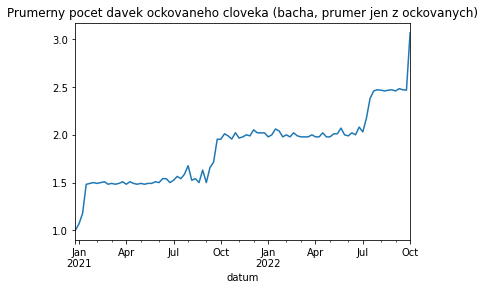

In [10]:
df_vaccination.groupby(df_vaccination.index.get_level_values('datum'))['poradi_davky'].mean().plot()
plt.title('Prumerny pocet davek ockovaneho cloveka (bacha, prumer jen z ockovanych)')

In [11]:
# df_vaccination[df_vaccination['vekova_skupina'] == '80-100'].xs('M', level=1)#.plot(y='pocet_davek')

## Model

- ještě mi to padá na nějaké chybě, ale po nalezení již by měl být hotový bod 1, 2, 4, 5

In [12]:
counts = []
counts_marked = []

In [13]:
weeks = sorted(df_deaths.index.get_level_values('datum').unique())

In [14]:
# TODO: Pozor, je tu problem. Pri zaokrouhleni veku na 5ky 
#  nespadne treba do intervalu 16–17 nikdo (z `persons`)! Zatim jsem neresil.
#  ---> Vyreseno

# NOTE: Pro zrychleni lze pouzivat .itertuples misto .iterrows, viz:
#  https://medium.com/swlh/why-pandas-itertuples-is-faster-than-iterrows-and-how-to-make-it-even-faster-bc50c0edd30d

# NOTE: np.random.choice ma tu vyhodu, ze lze vyuzit parameter vah `p` pro pridani korelace vakcinace s umrtimi.

# NOTE: Nemuze byt porovnavani poctu ockovanych lidi s celkovym poctem lidi jeste ovlivneno tim, ze v `persons`
#  je jen cast populace (deleno pomoci `SCALE`)?
#  Toto je dost dulezite, protoze si mnohem rychleji vyockujeme celou populaci.
#  Mozne reseni 1: v dane skupine `row` vydelit `SCALE`
#  Mozne reseni 2: aspon pro debug/vyvoj nastavit `SCALE = 1`

In [15]:
len(weeks)

51

In [16]:
for k, week in tqdm(enumerate(weeks)):

    # -------- Mark newly vaccinated --------
    # Dva radky nize jsou super sofistikovany (a elegantni) pandas trik
    #  .groupby('poradi_davky') rozdeli tyden na casti podle sloupce `poradi_davky`
    #  nasledne iteruji pres vsechny 1. vakciny vyockovane v danem tydnu, vsechny 2., ...
    grouped_vaccination_week = df_vaccination.loc[week].groupby('poradi_davky')
    for davka, vacc_week in grouped_vaccination_week:
        print(f'Zpracovavam {davka}. davku...')
        # print(vacc_week)
        # print('*'*5)

        for gender, row in vacc_week.iterrows():
            if row['pocet_davek'] == 0:
                continue
            age = tuple(int(a) for a in row['vekova_skupina'].split("-"))
            
            # Vyberu lidi s danym pohlavim, v danem vekovem intervalu
            #  a se spravnym poctem davek (tj. ockovana davka - 1).
            cohort = persons[
                (persons["pohlavi"] == gender) &
                (persons["vek"] >= age[0]) &
                (persons["vek"] <= age[1]) &
                (persons["davek_v_tele"] == davka-1)
            ]

            if row['pocet_davek'] > len(cohort):
                print('Neco je divne, mam ockovat vice lidi nez je v dane skupine.')
                print(f"**** Je tyden {week:%Y-%m-%d} a ja ve vekove skupine {row['vekova_skupina']:>6} vyberu"
                      f"{row['pocet_davek']:>7,d} ockovanych z {len(cohort):>7,d} moznych")
                continue

            # Nahodne vyberu kdo bude v dane skupine vakcinovany.
            sampled_indices = cohort.sample(n=row['pocet_davek'], replace=False).index
            persons.loc[sampled_indices, "davek_v_tele"] += 1

            # Vypisu co se deje. Model ma dost pohyblivych casti.
            print(f"Je {week:%Y-%m-%d} a ve věkové skupině {row['vekova_skupina']:>6} vyberu"
                  f"{row['pocet_davek']:>7,d} lidí s {davka-1} dávkami z {len(cohort):>7,d} možných, "
                  f"které tento týden naočkuji.")
    
    # TODO: Odstranit, jen pro debug.
    if k >= 3:
        break

#     # -------- Remove dead people --------
#     for n, row in dfd[dfd["datum"] == week].iterrows():
#         if row.hodnota > 0:
#             fi = persons[
#                 (persons["pohlavi"] == row.pohlavi) &
#                 (persons["vek"] == row.vek)
#             ].sample(n=row.hodnota).index
#             persons = persons[~persons.index.isin(fi)]

#     counts.append(len(persons))
#     counts_marked.append(sum(persons["mark"] == True))

#     break

0it [00:00, ?it/s]

Zpracovavam 1. davku...
Je 2021-01-10 a ve věkové skupině  16-17 vyberu      9 lidí s 0 dávkami z   9,496 možných, které tento týden naočkuji.
Je 2021-01-10 a ve věkové skupině  18-24 vyberu    805 lidí s 0 dávkami z  32,458 možných, které tento týden naočkuji.
Je 2021-01-10 a ve věkové skupině  25-29 vyberu  1,697 lidí s 0 dávkami z  29,054 možných, které tento týden naočkuji.
Je 2021-01-10 a ve věkové skupině  30-34 vyberu  1,540 lidí s 0 dávkami z  33,349 možných, které tento týden naočkuji.
Je 2021-01-10 a ve věkové skupině  35-39 vyberu  2,260 lidí s 0 dávkami z  34,736 možných, které tento týden naočkuji.
Je 2021-01-10 a ve věkové skupině  40-44 vyberu  3,458 lidí s 0 dávkami z  41,461 možných, které tento týden naočkuji.
Je 2021-01-10 a ve věkové skupině  45-49 vyberu  3,972 lidí s 0 dávkami z  42,688 možných, které tento týden naočkuji.
Je 2021-01-10 a ve věkové skupině  50-54 vyberu  3,141 lidí s 0 dávkami z  33,716 možných, které tento týden naočkuji.
Je 2021-01-10 a ve věkov

1it [00:01,  1.94s/it]

Je 2021-01-10 a ve věkové skupině  55-59 vyberu      1 lidí s 1 dávkami z     921 možných, které tento týden naočkuji.
Je 2021-01-10 a ve věkové skupině  60-64 vyberu      1 lidí s 1 dávkami z     921 možných, které tento týden naočkuji.
Zpracovavam 1. davku...
Je 2021-01-17 a ve věkové skupině  16-17 vyberu     30 lidí s 0 dávkami z   9,487 možných, které tento týden naočkuji.
Je 2021-01-17 a ve věkové skupině  18-24 vyberu  1,518 lidí s 0 dávkami z  31,653 možných, které tento týden naočkuji.
Je 2021-01-17 a ve věkové skupině  25-29 vyberu  2,238 lidí s 0 dávkami z  27,357 možných, které tento týden naočkuji.
Je 2021-01-17 a ve věkové skupině  30-34 vyberu  2,306 lidí s 0 dávkami z  31,809 možných, které tento týden naočkuji.
Je 2021-01-17 a ve věkové skupině  35-39 vyberu  3,667 lidí s 0 dávkami z  32,476 možných, které tento týden naočkuji.
Je 2021-01-17 a ve věkové skupině  40-44 vyberu  5,484 lidí s 0 dávkami z  38,003 možných, které tento týden naočkuji.
Je 2021-01-17 a ve věkov

2it [00:04,  2.54s/it]

Je 2021-01-17 a ve věkové skupině 80-100 vyberu      1 lidí s 1 dávkami z   3,581 možných, které tento týden naočkuji.
Zpracovavam 1. davku...
Je 2021-01-24 a ve věkové skupině  16-17 vyberu     12 lidí s 0 dávkami z   9,457 možných, které tento týden naočkuji.
Je 2021-01-24 a ve věkové skupině  18-24 vyberu    805 lidí s 0 dávkami z  30,135 možných, které tento týden naočkuji.
Je 2021-01-24 a ve věkové skupině  25-29 vyberu  1,132 lidí s 0 dávkami z  25,119 možných, které tento týden naočkuji.
Je 2021-01-24 a ve věkové skupině  30-34 vyberu  1,340 lidí s 0 dávkami z  29,503 možných, které tento týden naočkuji.
Je 2021-01-24 a ve věkové skupině  35-39 vyberu  2,096 lidí s 0 dávkami z  28,809 možných, které tento týden naočkuji.
Je 2021-01-24 a ve věkové skupině  40-44 vyberu  3,390 lidí s 0 dávkami z  32,519 možných, které tento týden naočkuji.
Je 2021-01-24 a ve věkové skupině  45-49 vyberu  4,155 lidí s 0 dávkami z  32,223 možných, které tento týden naočkuji.
Je 2021-01-24 a ve věkov

3it [00:07,  2.79s/it]

Je 2021-01-24 a ve věkové skupině  65-69 vyberu    281 lidí s 1 dávkami z   3,492 možných, které tento týden naočkuji.
Je 2021-01-24 a ve věkové skupině  70-74 vyberu    175 lidí s 1 dávkami z   2,883 možných, které tento týden naočkuji.
Je 2021-01-24 a ve věkové skupině  75-79 vyberu     80 lidí s 1 dávkami z   2,092 možných, které tento týden naočkuji.
Je 2021-01-24 a ve věkové skupině 80-100 vyberu    175 lidí s 1 dávkami z   3,580 možných, které tento týden naočkuji.
Zpracovavam 1. davku...
Je 2021-01-31 a ve věkové skupině  16-17 vyberu     14 lidí s 0 dávkami z   9,445 možných, které tento týden naočkuji.
Je 2021-01-31 a ve věkové skupině  18-24 vyberu    496 lidí s 0 dávkami z  29,330 možných, které tento týden naočkuji.
Je 2021-01-31 a ve věkové skupině  25-29 vyberu    570 lidí s 0 dávkami z  23,987 možných, které tento týden naočkuji.
Je 2021-01-31 a ve věkové skupině  30-34 vyberu    604 lidí s 0 dávkami z  28,163 možných, které tento týden naočkuji.
Je 2021-01-31 a ve věkov

3it [00:11,  3.68s/it]

Je 2021-01-31 a ve věkové skupině  60-64 vyberu    732 lidí s 1 dávkami z   3,752 možných, které tento týden naočkuji.
Je 2021-01-31 a ve věkové skupině  65-69 vyberu    588 lidí s 1 dávkami z   3,736 možných, které tento týden naočkuji.
Je 2021-01-31 a ve věkové skupině  70-74 vyberu    375 lidí s 1 dávkami z   3,111 možných, které tento týden naočkuji.
Je 2021-01-31 a ve věkové skupině  75-79 vyberu    180 lidí s 1 dávkami z   2,373 možných, které tento týden naočkuji.
Je 2021-01-31 a ve věkové skupině 80-100 vyberu    227 lidí s 1 dávkami z  13,256 možných, které tento týden naočkuji.
